In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [2]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])


In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,9999.998732,0.996949,0.134761,10000.001268
1,9999.996849,0.997237,0.134800,10000.003151
2,9999.994966,0.997245,0.134802,10000.005034
3,9999.993083,0.996937,0.134760,10000.006917
4,9999.991199,0.997067,0.134778,10000.008801
...,...,...,...,...
3001255,4347.829323,0.944661,0.015909,22999.982882
3001256,4347.827440,0.938258,0.015800,22999.992845
3001257,4347.825556,0.934484,0.015736,23000.002807
3001258,4347.823673,0.930303,0.015666,23000.012770


In [4]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\new_values_fe.xlsx")

raw_lambda

,Nave list
0,10035.6094
1,10067.8047
2,10084.1584
3,10087.8409
4,10092.5415
...,...
186,17688.7397
187,17775.9796
188,20722.6098
189,21254.7576


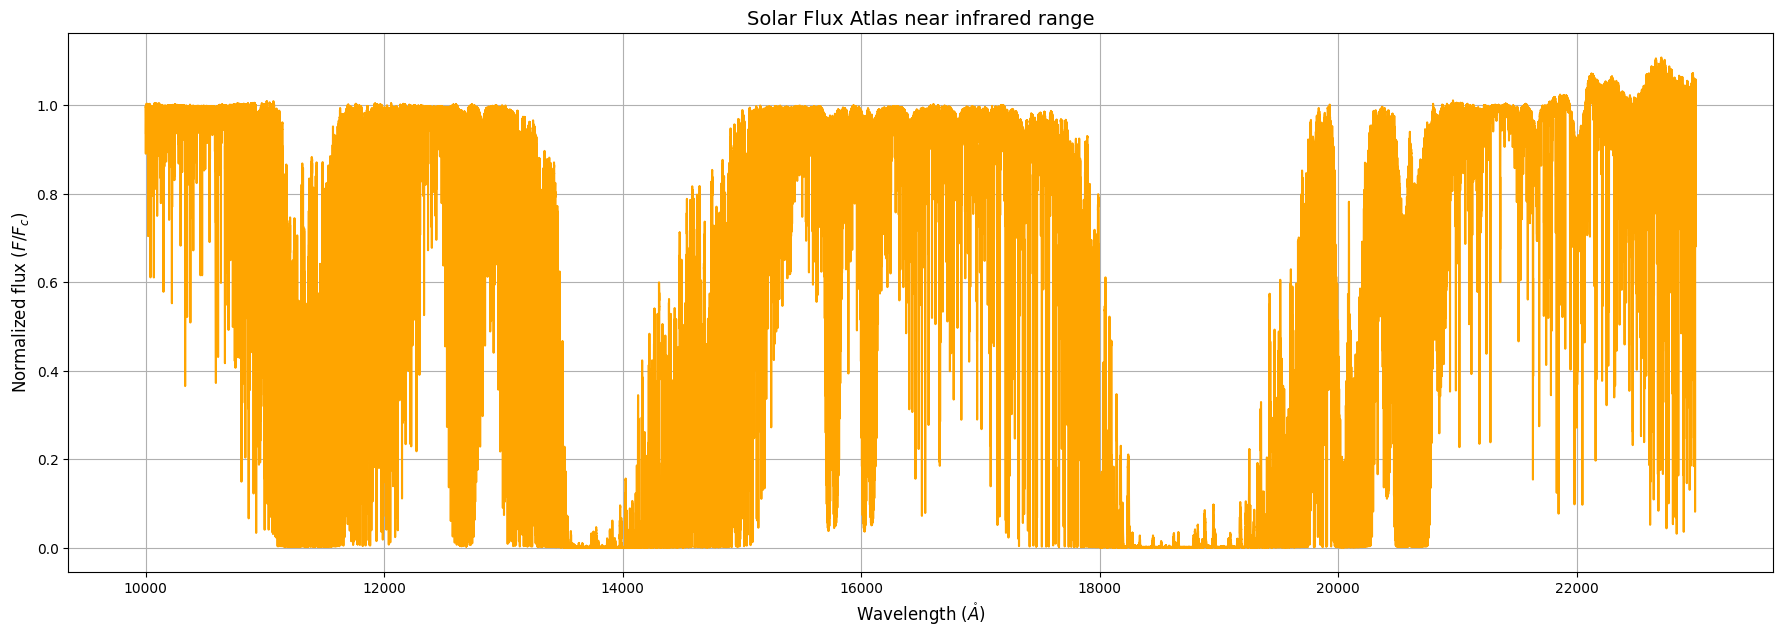

In [5]:
#Plot of raw data
fig1, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(raw_data['Wave A'],raw_data['nFlux'], color='orange')
ax.set_title('Solar Flux Atlas near infrared range',fontsize=14)
ax.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=12)
ax.set_ylabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.grid()

# fig1.savefig('Spectrum_NIR.png')

### Find the minimums and the closer line of the Fe I line


In [6]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10035.604601,0.942222,10035.6094
1,10067.811226,0.611177,10067.8047
2,10084.158793,0.956740,10084.1584
3,10087.835211,0.968803,10087.8409
4,10092.540490,0.956926,10092.5415
...,...,...,...
186,17688.748683,0.728781,17688.7397
187,17775.974602,0.617705,17775.9796
188,20722.619681,0.760236,20722.6098
189,21254.756444,0.982279,21254.7576


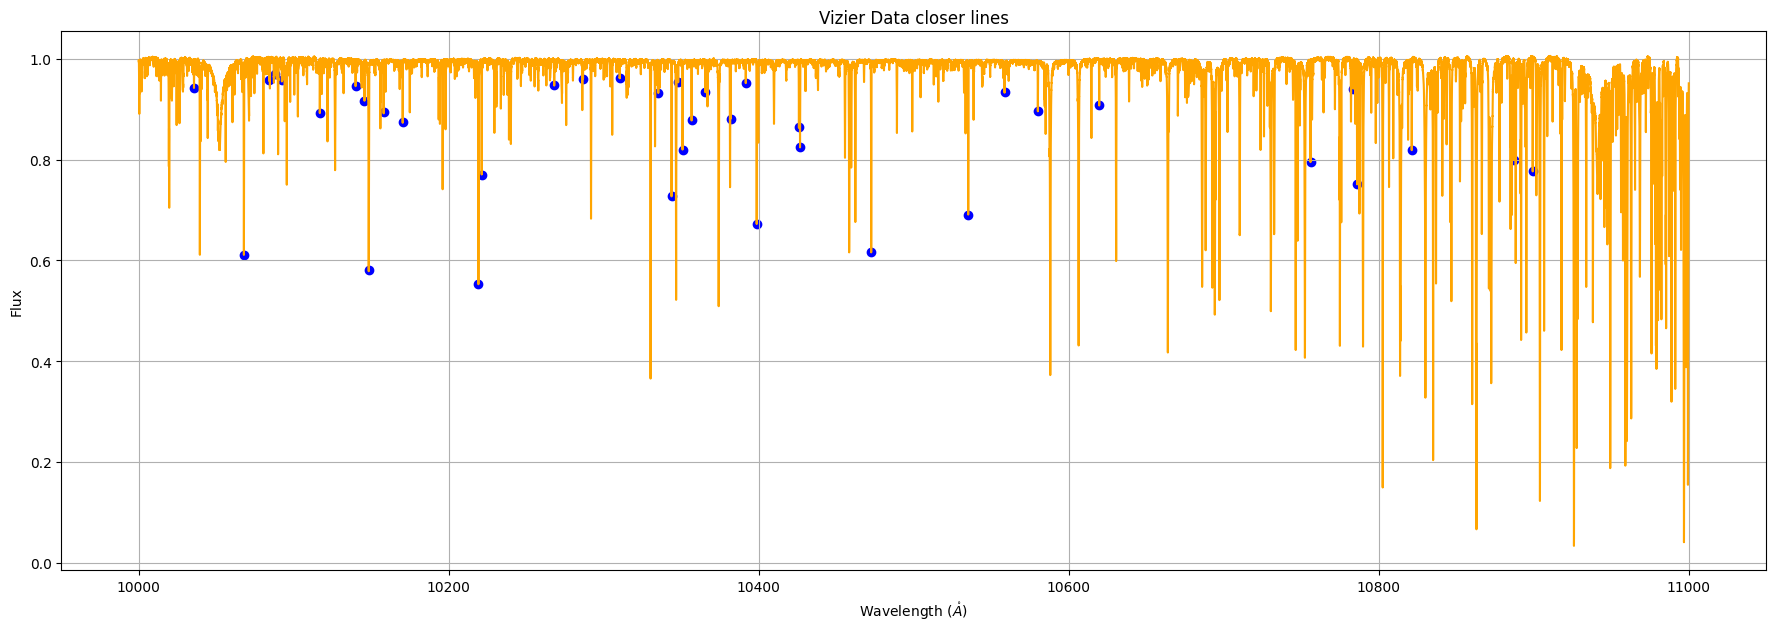

In [7]:
#Plot the identified lines
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
closer_lines_10000_11000 = closer_lines[closer_lines['Fe line'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_10000_11000['Wave A'],data_10000_11000['nFlux'], color='orange')
ax.scatter(closer_lines_10000_11000['min_wave'],closer_lines_10000_11000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [8]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points


local_points = width_minimums(closer_lines,raw_data,0.05)


### Derivates and fit

In [9]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) 
            d3 = (Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, Core curvature, Bisector slope, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),-d3*(const.c/lamda_obs[0]),blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift"]

    return Values,fit

Values,fit = Fit_derivates(local_points,closer_lines['Fe line'])

Values

,Emitted wavelength,Observed wavelength,Flux,Velocity,Core curvature,Bisector slope,Blueshift
0,10035.6094,10035.6164,0.942566,-424,1.092415e+09,-1.566771e+08,209.110092
1,10067.8047,10067.8169,0.611079,-270,5.206249e+09,1.851921e+07,363.283565
2,10084.1584,10084.1685,0.956635,-333,1.039917e+09,-9.578404e+07,300.263414
3,10087.8409,10087.8493,0.967970,-383,6.806769e+08,-2.351509e+08,249.632867
4,10092.5415,10092.5375,0.957501,-752,5.799208e+08,2.155852e+08,-118.817429
...,...,...,...,...,...,...,...
186,17688.7397,17688.7463,0.728788,-521,2.313139e+09,1.274777e+07,111.858180
187,17775.9796,17775.9768,0.617794,-680,2.741667e+09,3.340482e+07,-47.222089
188,20722.6098,20722.6196,0.760462,-491,1.991439e+09,1.287963e+08,141.775873
189,21254.7576,21254.7553,0.982199,-665,1.418032e+09,7.555657e+07,-32.440862


In [10]:
# Values.to_excel('valores_NIR.xlsx',index=False)

## Graphics 
As we have an absorption spectrum, the line depth is measurement one minus the flux value.

### Velocity vs Normalized Flux

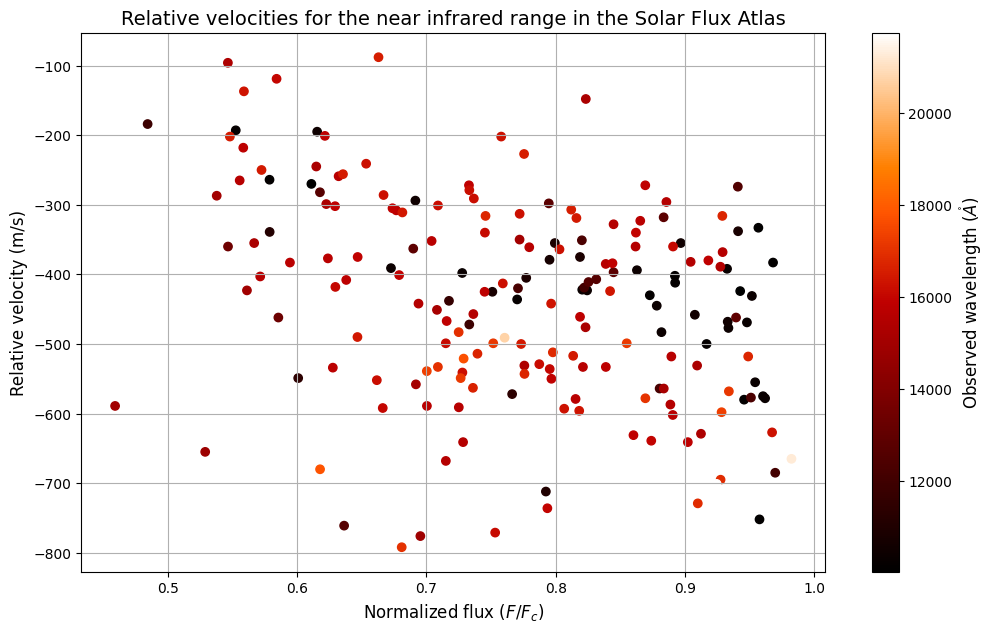

In [12]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Relative velocities for the near infrared range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$', fontsize=12)
ax.set_ylabel('Relative velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity_NIR.png')

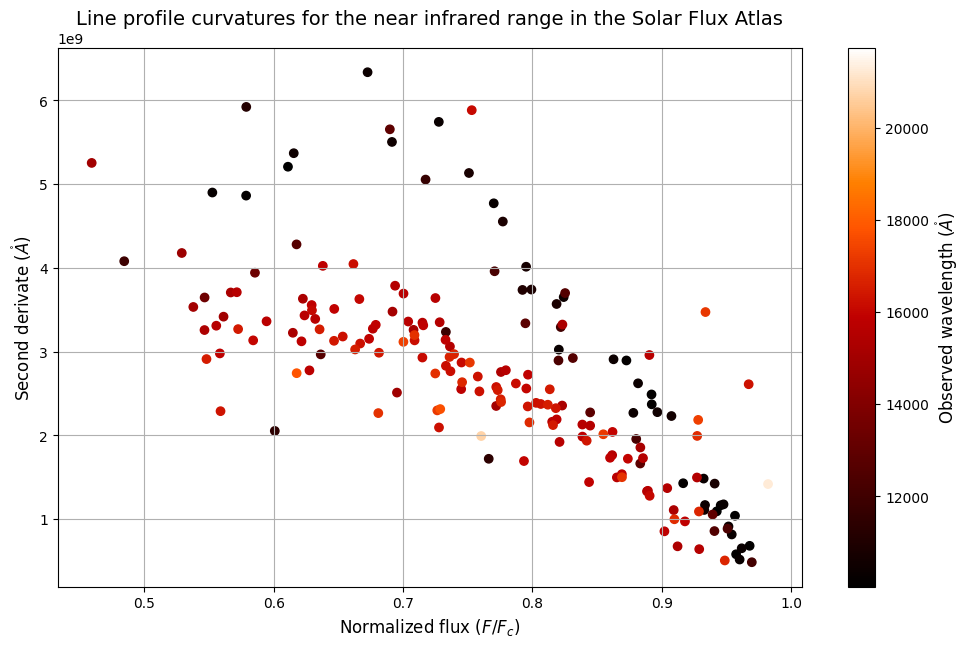

In [13]:
fig4, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Core curvature'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile curvatures for the near infrared range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()

# fig4.savefig('Curvature_NIR.png')

### Third Derivate Expresion vs Normalized Flux

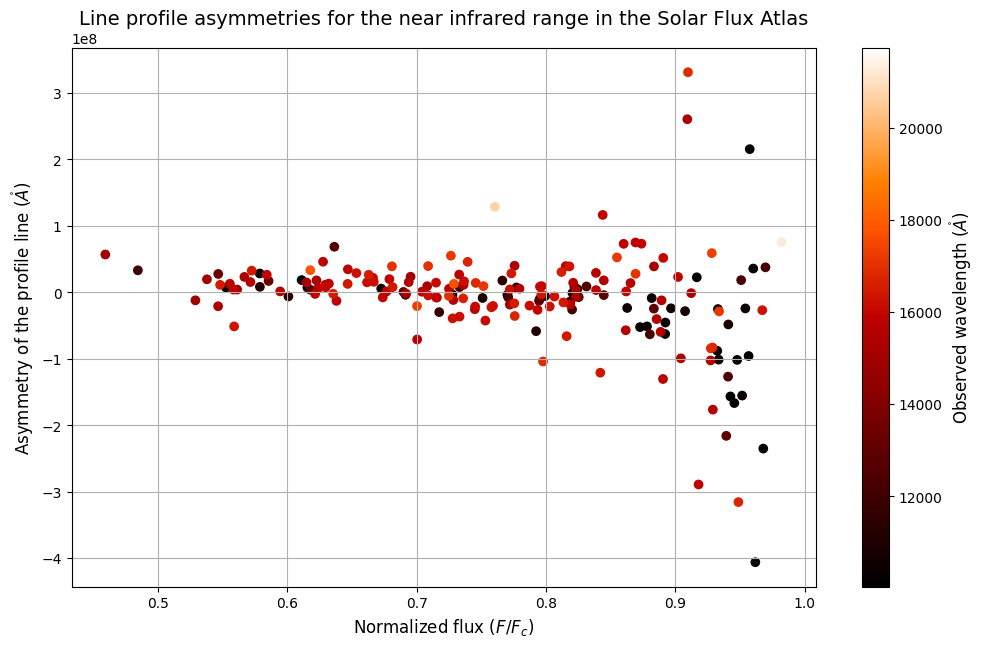

In [14]:
fig5, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Bisector slope'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile asymmetries for the near infrared range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Asymmetry of the profile line $(\mathring{A})$',fontsize=12)
ax.grid()

# fig5.savefig('CBisector_NIR.png')

### Convective Blueshift vs Line Depth

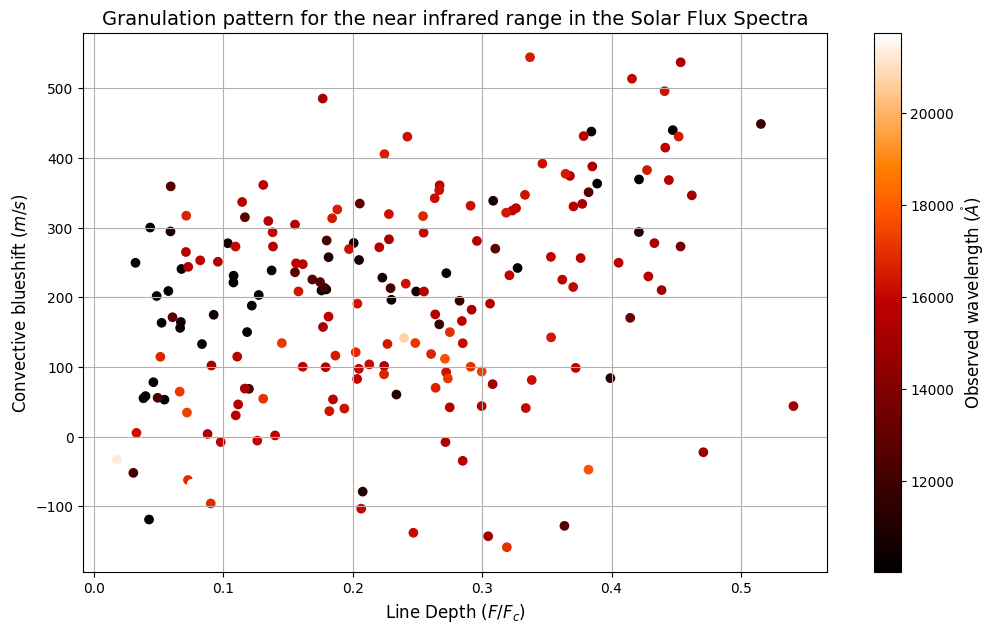

In [15]:
fig6, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Blueshift'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Granulation pattern for the near infrared range in the Solar Flux Spectra',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift_NIR.png')